In [1]:
import numpy as np
import sys, os, time
import data
import architecture
import optuna
import utils as U

%pylab inline

/home/aobulj/data/conda/envs/torch_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
sim  = 'Hi-Fi_mocks_noise_smooth2D_1000'  
arch = 'o3'
study_name   = 'wd_dr_hidden_lr_full_noise_smooth2D_%s'%arch
root_storage = 'sqlite:///../../scripts/mocks_noise_smooth2D/databases_%s/%s'%(sim,arch)
storage = U.fname_storage(root_storage, None, monopole=True)
study = optuna.create_study(study_name=study_name, storage=storage, load_if_exists=True)
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

[I 2024-05-08 17:14:03,860] Using an existing study with name 'wd_dr_hidden_lr_full_noise_smooth2D_o3' instead of creating a new one.


In [3]:
print (df.to_string())
print (study.best_trial)

    number      value  params_dr  params_hidden  params_lr     params_wd     state
0        0  -9.988366   0.151238             10   0.000013  5.625898e-06  COMPLETE
1        1  -9.103437   0.337118             12   0.000010  2.571523e-05  COMPLETE
2        2 -10.698225   0.286553              6   0.000065  6.854813e-02  COMPLETE
3        3 -11.258754   0.430602              8   0.000458  3.836546e-04  COMPLETE
4        4 -11.284132   0.559254              9   0.000936  4.988549e-03  COMPLETE
5        5 -11.302824   0.584675              8   0.000556  3.387634e-05  COMPLETE
6        6 -10.342879   0.060994              7   0.000011  4.100644e-03  COMPLETE
7        7 -10.193310   0.016688             12   0.000075  1.597497e-08  COMPLETE
8        8  -9.219170   0.867781             10   0.003493  2.500941e-08  COMPLETE
9        9 -11.279852   0.605447             11   0.001107  2.718024e-05  COMPLETE
10      10 -11.294147   0.412945             10   0.000356  4.797832e-07  COMPLETE
11  

Number of files in /shares/stadel.ics.mnf.uzh/aobulj/hifi_mocks_Paco_noise/cnn_full_noise_smooth2D/losses_Hi-Fi_mocks_noise_smooth2D_1000/: 89


Text(0.5, 1.0, 'testing loss')

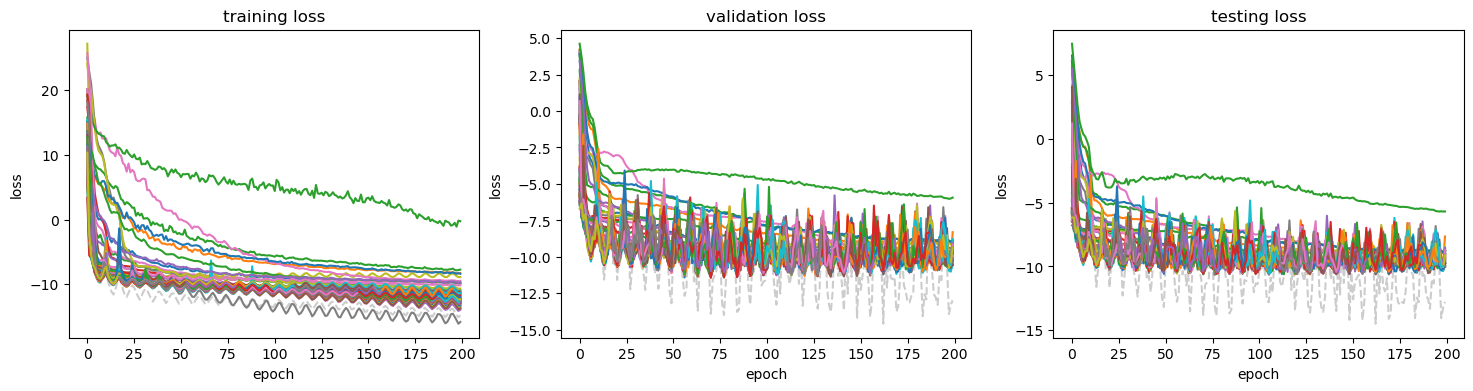

In [4]:
# load losses:
path = '/shares/stadel.ics.mnf.uzh/aobulj/hifi_mocks_Paco_noise/cnn_full_noise_smooth2D/losses_Hi-Fi_mocks_noise_smooth2D_1000/' #output folder
num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
print(f"Number of files in {path}: {num_files}")

fig, ax = subplots(1, 3, figsize=(18,4))

path_prev = '/shares/stadel.ics.mnf.uzh/aobulj/hifi_mocks_Paco_noise/cnn_full_noise/losses_Hi-Fi_mocks_noise_1000/' #output folder
# path_prev = '/shares/stadel.ics.mnf.uzh/aobulj/hifi_mocks_Paco/cnn_full/losses_Hi-Fi_mocks_1000/' #output folder
loss_prev = np.loadtxt(path_prev + 'loss_fiducial_56.txt', unpack=True)

for i in range(num_files):
    if i==0: [ax[j].plot(loss_prev[0,:], loss_prev[j+1,:], '--', c='gray', label = 'no smoothing', alpha=0.4) for j in range(3)]
    loss = np.loadtxt(path + 'loss_fiducial_%i.txt'%i, unpack=True)
    for j in range(3):
            ax[j].plot(loss[0,:], loss[j+1,:], label = '%i'%i)
        
for i in range(3):
    ax[i].set_xlabel("epoch")
    ax[i].set_ylabel("loss")
ax[0].set_title("training loss")
ax[1].set_title("validation loss")
ax[2].set_title("testing loss")
# legend(loc=0, ncol=2, fontsize=6)
# semilogy()
# plt.savefig("Losses_Hi-Fi_mocks_CNN_1000.pdf", bbox_inches='tight')

In [5]:
study.best_trial

FrozenTrial(number=67, state=1, values=[-11.416881561279297], datetime_start=datetime.datetime(2024, 2, 6, 5, 31, 31, 82975), datetime_complete=datetime.datetime(2024, 2, 6, 11, 30, 42, 182637), params={'lr': 0.0018051670865710555, 'wd': 7.857058678100841e-08, 'dr': 0.481422871135651, 'hidden': 11}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr': FloatDistribution(high=0.005, log=True, low=1e-05, step=None), 'wd': FloatDistribution(high=0.1, log=True, low=1e-08, step=None), 'dr': FloatDistribution(high=0.9, log=False, low=0.0, step=None), 'hidden': IntDistribution(high=12, log=False, low=6, step=1)}, trial_id=68, value=None)

In [7]:
dataset = np.loadtxt("../../scripts/mocks_noise_smooth2D/results_train_Hi-Fi_mocks_noise_smooth2D_1000_fiducial_None_test_Hi-Fi_mocks_noise_1000_None_LH.txt")
dataset.shape
params_true = dataset[:,:6]
params_NN = dataset[:,6:12]
errors_NN = dataset[:,12:]

Selected 9600 maps out of 9600
params_true.shape, splits (9600, 6) 192
(50,)


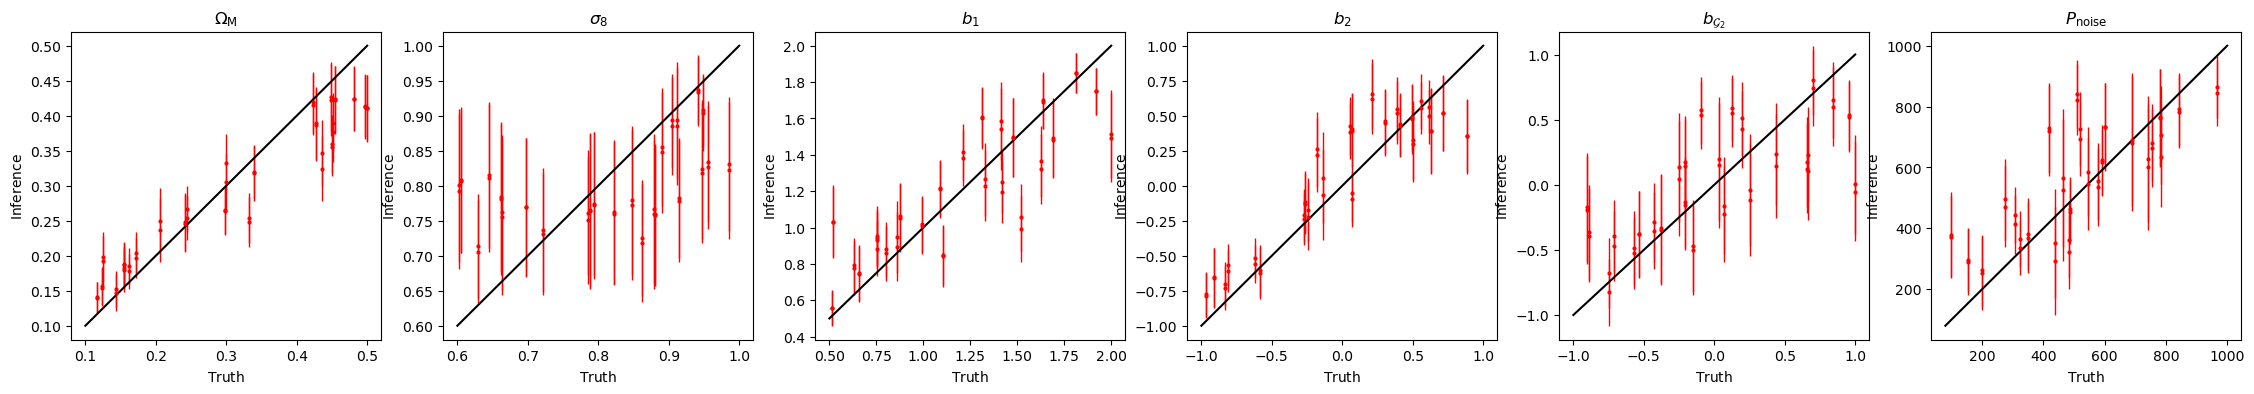

In [8]:
# # define the array that will contain the indexes of the maps
indexes = np.zeros(params_true.shape[0], dtype=np.int32)

splits = 192

# do a loop over all maps and choose the ones we want
count = 0
for i in range(params_true.shape[0]):
    if i%splits in np.arange(splits):
      indexes[count] = i
      count += 1
print('Selected %d maps out of %i'%(count, params_true.shape[0]))

print ('params_true.shape, splits', params_true.shape, splits)

indexes = np.arange(50)*splits
print (indexes.shape)

minimum = np.array([0.1, 0.6, 0.5, -1.0, -1.0, 80])
maximum = np.array([0.5, 1.0, 2.0,  1.0,  1.0, 1000])


dataset.shape
fig, ax = plt.subplots(1,6,figsize=(28,4))
param_names = ['$\\Omega_\mathrm{M}$', '$\\sigma_8$', '$b_1$', '$b_2$', '$b_{\\mathcal{G}_2}$', '$P_\\mathrm{noise}$']
for i in range(6):
    ax[i].errorbar(params_true[indexes,i], params_NN[indexes,i], errors_NN[indexes,i],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
    ax[i].plot([minimum[i],maximum[i]], [minimum[i],maximum[i]], color='k')
    ax[i].set_xlabel(r'${\rm Truth}$')
    ax[i].set_ylabel(r'${\rm Inference}$')
    ax[i].set_title(param_names[i])
# plt.errorbar(params_true[indexes,i], params_NN[indexes,i], errors_NN[indexes,i],
#                  linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')

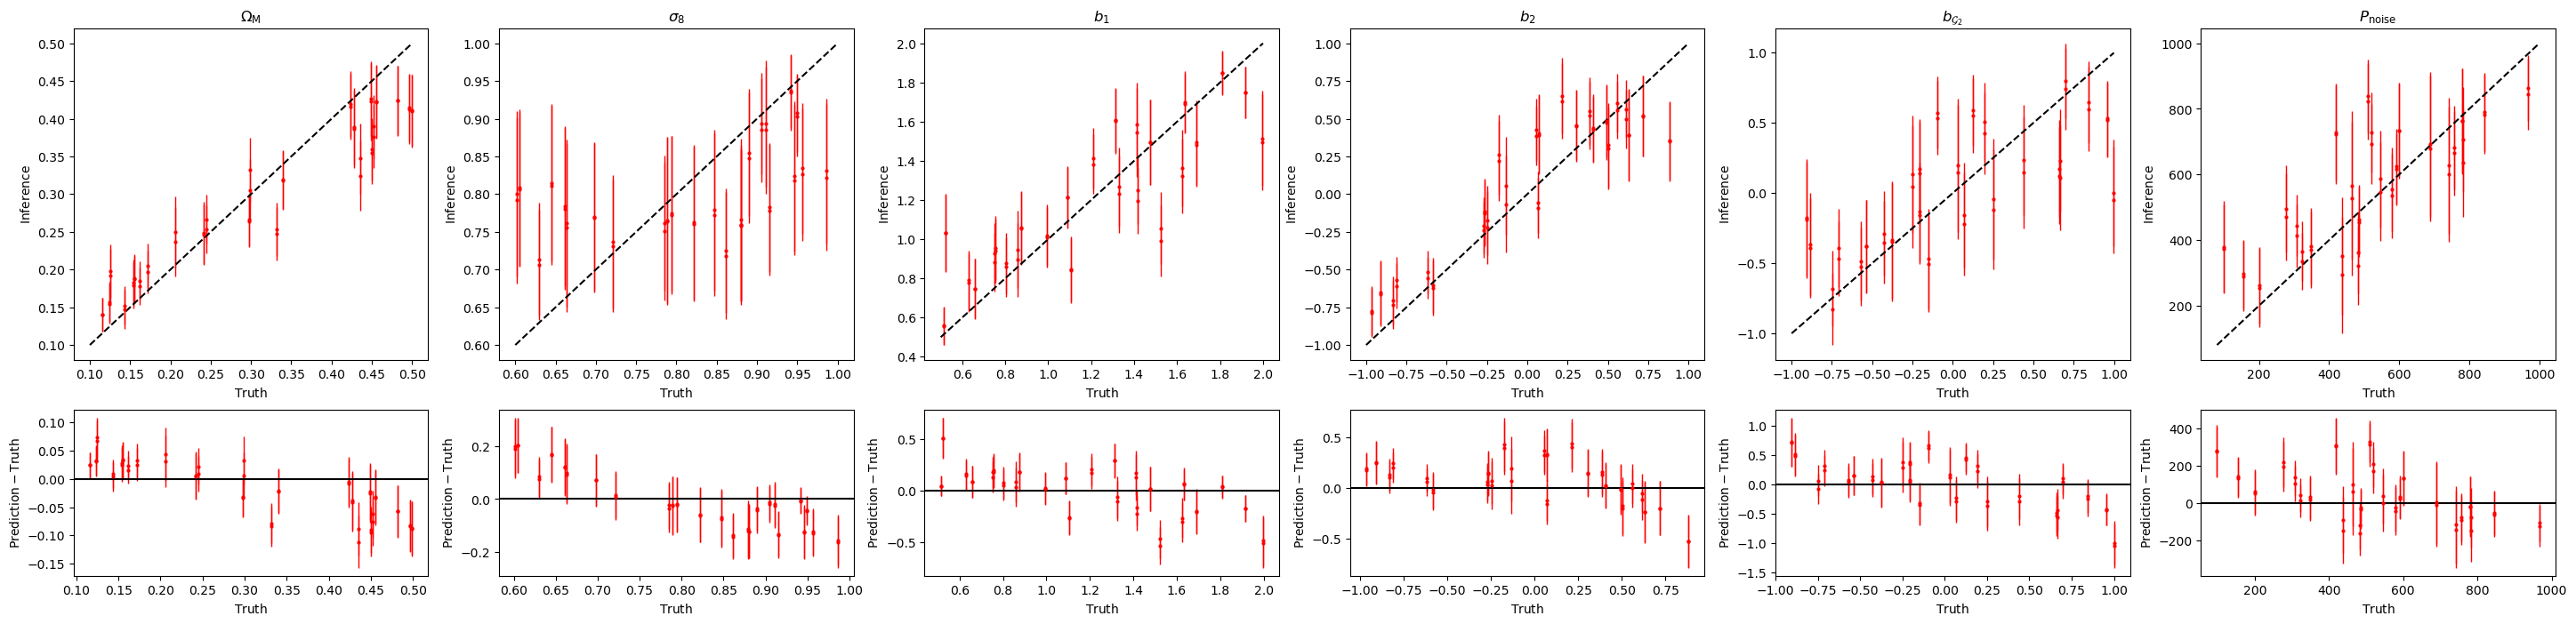

In [9]:
fig, ax = plt.subplots(2,6,figsize=(36,8), height_ratios=[2, 1])
param_names = ['$\\Omega_\mathrm{M}$', '$\\sigma_8$', '$b_1$', '$b_2$', '$b_{\\mathcal{G}_2}$', '$P_\\mathrm{noise}$']
for i in range(6):
    ax[0,i].errorbar(params_true[indexes,i], params_NN[indexes,i], errors_NN[indexes,i],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
    ax[1,i].errorbar(params_true[indexes,i], params_NN[indexes,i]-params_true[indexes,i], errors_NN[indexes,i],
             linestyle='None', lw=1, fmt='o', ms=2, elinewidth=1, capsize=0, c='r')
    ax[0,i].plot([minimum[i],maximum[i]], [minimum[i],maximum[i]], '--', color='k')
    ax[1,i].axhline(0, c='k')
    ax[0,i].set_xlabel(r'${\rm Truth}$')
    ax[1,i].set_xlabel(r'${\rm Truth}$')
    ax[0,i].set_ylabel(r'${\rm Inference}$')
    ax[1,i].set_ylabel(r'${\rm Prediction - Truth}$')
    ax[0,i].set_title(param_names[i])

Number of files in /shares/stadel.ics.mnf.uzh/aobulj/hifi_mocks_Paco/cnn_full_init/losses_Hi-Fi_mocks_1000/: 9


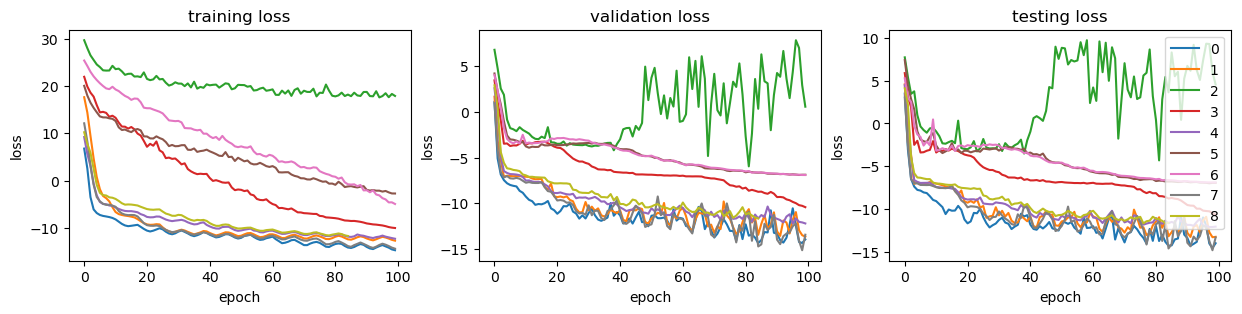

In [10]:
# load losses:
path = '/shares/stadel.ics.mnf.uzh/aobulj/hifi_mocks_Paco/cnn_full_init/losses_Hi-Fi_mocks_1000/' #output folder
num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
print(f"Number of files in {path}: {num_files}")

fig, ax = subplots(1, 3, figsize=(15,3))

for i in range(num_files):
    loss = np.loadtxt(path + 'loss_fiducial_%i.txt'%i, unpack=True)
    for j in range(3):
        ax[j].plot(loss[0,:], loss[j+1,:], label = '%i'%i)
for i in range(3):
    ax[i].set_xlabel("epoch")
    ax[i].set_ylabel("loss")
ax[0].set_title("training loss")
ax[1].set_title("validation loss")
ax[2].set_title("testing loss")
legend(loc=0)